## Divisão de Dados - Reamostragem

# Validação Cruzada: Avaliando a performance dos estimadores

Treinar um modelo de aprendizagem e testá-lo nos mesmos dados é um erro metodológico: pode gerar um modelo capaz de repetir perfeitamente os rótulos das amostras já conhecidas mas que falha ao predizer o valor de novos dados desconhecidos. Esse problema, como já vimos, é chamado de overfitting. Uma prática comum para evitá-lo é manter uma parte dos dados disponíveis como conjunto de teste. Abaixo temos um fluxograma típico do fluxo de treinamento com otimização de hiper-parâmetros com validação cruzada (_cross validation_ ). Os melhores parâmetros podem ser encontrados utilizando técnicas de busca em grade, busca aleatória ou otimização meta-heurística.

<img src='https://github.com/ai2-education-fiep-turma-4/04-machine-learning/blob/main/exercicios/aula2/assets/grid_search_workflow.png?raw=1' width=500px>

No Scikit-Learn, podemos separar rápidamente nosso conjunto de dados em treino e teste com a já conhecida função `train_test_split`. Vamos carregar o dataset iris e treinar o Regressor Logístico nele.

In [ ]:
import warnings
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')

X, y = datasets.load_iris(return_X_y=True)
print(X.shape, y.shape)
print("Sample:", X[0,:])

(150, 4) (150,)
Sample: [5.1 3.5 1.4 0.2]


Agora podemos separar o conjunto de dados usando 60% para treinamento e 40% para teste (avaliação) do nosso classificador:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0)

print('X_train.shape, y_train.shape = ', X_train.shape, y_train.shape)

print('X_test.shape, y_test.shape = ', X_test.shape, y_test.shape)

model = LogisticRegression(C=1,random_state=0)
model.fit(X_train, y_train)
model.score(X_test, y_test)

X_train.shape, y_train.shape =  (90, 4) (90,)
X_test.shape, y_test.shape =  (60, 4) (60,)


0.9166666666666666

Quando avaliamos diferentes configurações de hyper-parâmetros, como por exemplo o $C$ no Regressor Logístico, ainda existe o risco de _overfitting_ no conjunto de testes por que o valor pode ser ajustado até que o resultado seja ótimizado. Assim, o conhecimento sobre os dados de teste podem "vazar" para o modelo e as métricas de avaliação deixam de reportar a performance real do modelo num cenário generalizado (com amostras desconhecidas).

Para resolver esse problema, outra parte do _dataset_ pode ser mantida, chamada de "conjunto de validação": treinamento é feito no conjunto de treinamento, na sequência o conjunto de validação é usado para avaliar o modelo, e após finalizar o treinamento, a avaliação do modelo em um cenário desconhecido é feita usando o conjunto de teste.

No entanto, ao particionar os dados disponíveis em 3 conjuntos, reduzimos drasticamente o número de amostras que podem ser usadas para treinar o modelo, e os resultados podem depender de uma escolha aleatória particular do par de conjuntos (treinamento, validação).

A solução para esse problema é a validação cruzada (CV). Um conjunto de teste continua sendo separado para a avaliação final, mas o conjunto de validação não é mais necessário. Na abordagem mais básica, chamada $k$-fold CV, o conjunto de treinamento é dividido $k$ conjuntos menores (outras abordagens seguem os mesmos princípios). O procedimento a seguir é executado para cada um dos $k$ "folds":

- O modelo é treinado usando $k-1$ _folds_ como dados de treinamento;

- O modelo resultante é validado nos dados restantes, i.e., esses dados são usados como teste para computar a performance do modelo;

A média das métricas reportadas pelo $k$-fold CV é computada. Essa abordagem é cara em termos computacionais, mas não desperdiça dados como quando separamos um conjunto de validação, sendo essa sua maior vantagem quando consideramos _datasets_ pequenos.

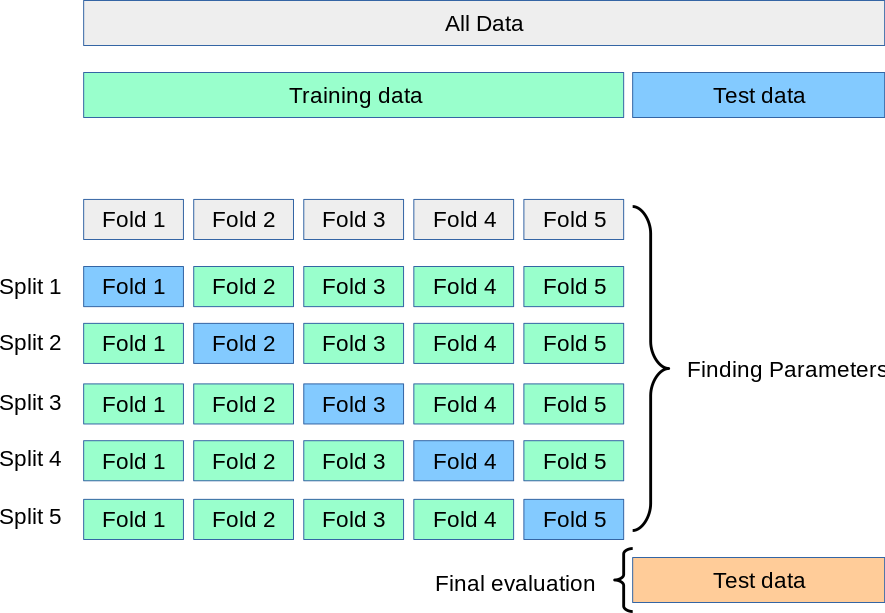


### Computando métricas com validação cruzada

O modo mais fácil de se computar o resultado da validação cruzada é usando a função `cross_val_score`, passando como parâmetro o estimador e o dataset.

O exemplo a seguir demonstra como estimar a acurácia do Regressor Logístico sobre o dataset _iris_ dividindo os dados, ajustando o modelo e computando os pontos 5 vezes consecutivas, com diferentes divisões do conjunto de treinamento a cada execução:

In [ ]:
from sklearn.model_selection import cross_val_score

# computa diretamente os valores as métricas de saída para cada execução da validação cruzada
scores = cross_val_score(model, X, y, cv=5)
print(scores)

[0.96666667 1.         0.93333333 0.96666667 1.        ]


O valor médio e o desvio padrão podem ser computado:

In [ ]:
print("%0.2f de acurácia com desvio padrão de %0.2f" % (scores.mean(), scores.std()))

0.97 de acurácia com desvio padrão de 0.02


O valor computado a cada iteração do CV é a métrica padrão do estimador. É possível trocá-la usando o parâmetro scoring:

In [ ]:
from sklearn import metrics

scores = cross_val_score(
    model, X, y, cv=5, scoring='f1_macro')
print(scores)

[0.96658312 1.         0.93265993 0.96658312 1.        ]


Outras métricas disponíveis podem ser encontradas [aqui](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter). No caso do _dataset_ iris, o número de amostras por classe é balanceado, então o F1-score e a acurácia são quase iguais.

Quando o argumento cv é um inteiro `cross_val_score` usa as estratégias [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) ou [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold), dependendo do caso.

Também é possível usar outras estratégias de validação cruzada passando um iterador, como, por exemplo:

In [ ]:
from sklearn.model_selection import ShuffleSplit
n_samples = X.shape[0]

# gera os 5 splits
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(model, X, y, cv=cv)

array([0.97777778, 0.93333333, 0.95555556, 0.91111111, 0.97777778])

### Validação cruzada com transformação dos dados

Assim como testar nosso modelo em dados não usados durante o treinamento, pré-processamento (como normalização, selecão de característica, etc.) e outras transformações similares devem ser executadas no conjunto de treinamento e aplicadas no conjunto de teste para predição:


In [ ]:
from sklearn import preprocessing

# divide os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0)

# cria um pré-processador para normalizar os dados
scaler = preprocessing.StandardScaler().fit(X_train)

# transforma os dados de treinamento
X_train_transformed = scaler.transform(X_train)

# treina o modelo
model = LogisticRegression(C=1,random_state=0).fit(X_train_transformed, y_train)

# transforma os dados de teste
X_test_transformed = scaler.transform(X_test)

# computa o resultado
model.score(X_test_transformed, y_test)

0.9333333333333333

Usando o método [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) deixa mais fácil organizar o processo, executando o comando com a validação cruzada:

In [ ]:
from sklearn.pipeline import make_pipeline

clf = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(random_state=0))
cross_val_score(clf, X, y, cv=cv)


array([0.97777778, 0.91111111, 0.95555556, 0.93333333, 0.95555556])

### A função `cross_validate` e a avaliação de múltiplas métricas

A função `cross_validate` se diferencia da função `cross_val_score` de 2 maneiras:

- ela permite especificar multiplas métricas para avaliação.

- ela retorna um dicionário contendo as métricas `fit-times`, `score-times` (e opcionalmente os resultados do treinamento e o modelo treinado), além dos resultados sobre o conjunto de testes.

Para avaliar uma única métrica, onde o parâmetro scoring é uma _string_, _callable_ ou _None_, as chaves do dicionário serão `['test_score', 'fit_time', 'score_time']`.

Para avaliar múltiplas métricas, o valor retornado é um dicionário com as seguintes chaves: `['test_<scorer1_name>', 'test_<scorer2_name>', 'test_<scorer...>', 'fit_time', 'score_time']`

`return_train_score` é setado para `False` por padrão para economizar tempo de processamento. para avaliar o resultados sobre o conjunto de treinamento é necessário setar esse valor para `True`.

Você também pode armazenar os modelos treinados setando `return_estimator=True`.

As múltiplas métricas podem ser especificadas tanto como uma lista, tupla, ou conjunto de nomes de marcadores:

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

# métricas a serem computadas
scoring = ['precision_macro', 'recall_macro']

# definindo o modelo
model = LogisticRegression(random_state=0)

# treinando o modelo com validação cruzada - Usando strings no scoring
scores = cross_validate(model, X, y, scoring=scoring)
# imprimindo as chaves
print(sorted(scores.keys()))

print(scores['test_precision_macro'])

['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']
[0.96969697 1.         0.94444444 0.96969697 1.        ]


Ou como um dicionário mapeando os marcadores para uma função:

In [ ]:
from sklearn.metrics import make_scorer

# monta o conjunto de métricas a ser retornado usando strings ('precision_macro') e callable (make_scorer)
scoring = {'prec_macro': 'precision_macro',
           'rec_macro': make_scorer(recall_score, average='macro')}

# treinando o modelo com validação cruzada - return_train_score=True para retornar os resultados sobre
#    o conjunto de treinamento
scores = cross_validate(model, X, y, scoring=scoring,
                        cv=5, return_train_score=True)
print(sorted(scores.keys()))

#scores['train_rec_macro']
print(scores['test_rec_macro'])

['fit_time', 'score_time', 'test_prec_macro', 'test_rec_macro', 'train_prec_macro', 'train_rec_macro']
[0.96666667 1.         0.93333333 0.96666667 1.        ]


Exemplo de validação cruzada usando uma única métrica:

In [ ]:
# passando return_estimator=True para retornar o modelo treinado
scores = cross_validate(model, X, y,
                        scoring='precision_macro', cv=5,
                        return_estimator=True)
sorted(scores.keys())

['estimator', 'fit_time', 'score_time', 'test_score']

### Obtendo os rótulos estimados com validação cruzada

A função [cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict) tem uma interface similar à `cross_val_score`, mas retorna os rótulos para cada amostra no momento em que foi classificada. O método não é indicado pois as amostras são agrupadas de forma aleatória e essa classificação dependerá do agrupamento.

Todo caso, ainda pode ser útil em 2 situações:
1. visualização dos dados obtidos de diferentes modelos
2. mistura de modelos, utilizado, por exemplo, em _ensamble_ de métodos (quando utilizamos a votação entre vários classificadores para encontrar o melhor resultado).


## Iteradores de validação cruzada

### Validação cruzada em dados independentes e distribuídos de forma idêntica

Assumir que os dados são independentes e distribuídos de forma idêntica (i.i.d.) é assumir que todas as amostras foram gerados a partir do mesmo processo de distribuição.

Para isso, podemos usar o famoso $k$-fold:

### $K$-fold

[KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) divide todas as amostras em grupos de amostras, chamados de _folds_ (se $k=n$, o modelo é equivalente à estratégia Leave One Out), de tamanhos iguais (se possível). O modelo é aprendido usando $k-1$ _folds_ e o _fold_ restante é usado pra teste.

Exemplo de validação cruzada 2-_fold_ em um _dataset_ com 4 amostras:

In [ ]:
import numpy as np
from sklearn.model_selection import KFold

X = ["a", "b", "c", "d"]
kf = KFold(n_splits=2)
for i, (train, test) in enumerate(kf.split(X)):
    # printa os indices dos conjuntos de treinamento e teste
    print("Fold %s - Treinamento: %s Teste: %s" % (i+1, train, test))

Fold 1 - Treinamento: [2 3] Teste: [0 1]
Fold 2 - Treinamento: [0 1] Teste: [2 3]


Cada _fold_ é constituido por 2 arrays: o primeiro está relacionado ao conjunto de treinamento e o segundo ao conjunto de teste. Sendo assim, poderiamos criar os conjuntos de treino/teste com os indices:

In [ ]:
X = np.array([[0., 0.], [1., 1.], [-1., -1.], [2., 2.]])
y = np.array([0, 1, 0, 1])
X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]

# considerando os indices treino [0 1] e teste [2 3] acima, temos
print('X_train = \n', X_train)
print('X_test = \n', X_test)
print('y_train = ', y_train)
print('y_test = ', y_test)

X_train = 
 [[0. 0.]
 [1. 1.]]
X_test = 
 [[-1. -1.]
 [ 2.  2.]]
y_train =  [0 1]
y_test =  [0 1]


### Outros métodos para dados independentes e distribuídos de forma idêntica

- [RepeatedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html#sklearn.model_selection.RepeatedKFold) - repete $k$-_folds_ $n$ vezes
- [Leave One Out (LOO)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html#sklearn.model_selection.LeaveOneOut) - similar ao $k$-_folds_ com $k=$ ao número de amostras
- [Leave P Out (LPO)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeavePOut.html#sklearn.model_selection.LeavePOut) - similar ao LOO, deixando $p$ amostras fora do processo. Nesse caso pode haver sobreposição de amostras.

## Validação cruzada com estratificação baseada nos rótulos


Alguns problemas de classificação apresentam uma distribuição de classes altamente desbalanceadas. Nesses casos, é recomendado usar [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold), que assegura a frequência e tenta preservar, aproximadamente, a distribuição das classes em cada divisão dos conjuntos de treinamento e teste.

### Stratified k-fold

[StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) é uma variação do $k$-fold que retorna os _folds_ estratificados: cada conjunto contém aproximadamente a mesma proporção de amostras de cada classe que o _dataset_ completo.

Aqui temos um exemplo de validação cruzada 3-_fold_ estratificada em um conjunto de dados com $50$ amostras com 2 classes desbalanceadas. Mostraremos o número de amostras de cada classe e compararemos com o $k$-_fold_.

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np
# gerando 50 amostras
X, y = np.ones((50, 1)), np.hstack(([0] * 45, [1] * 5))
print(X[:,0], y)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]


In [ ]:
skf = StratifiedKFold(n_splits=3)
for train, test in skf.split(X, y):
    print('train -  {}   |   test -  {}'.format(
        np.bincount(y[train]), np.bincount(y[test])))

train -  [30  3]   |   test -  [15  2]
train -  [30  3]   |   test -  [15  2]
train -  [30  4]   |   test -  [15  1]


In [ ]:
kf = KFold(n_splits=3)
for train, test in kf.split(X, y):
    print('train -  {}   |   test -  {}'.format(
        np.bincount(y[train]), np.bincount(y[test])))

train -  [28  5]   |   test -  [17]
train -  [28  5]   |   test -  [17]
train -  [34]   |   test -  [11  5]


Podemos observar que `StratifiedKFold` preserva a razão das classes (aproximadamente 1/10) tanto para os conjuntos de treinamento quanto de teste.


# Otimizando os hyper-parâmetros de um modelo

Hyper-parâmetros são parametros que não são aprendidos diretamente pelo modelo, e geralmente precisam ser escolhidos pelo usuário. Alguns exemplos típicos são o $C$ do Regressor Logístico, e o learning rate das redes neurais.

Uma prática recomendada é percorrer o espaço de busca desses hyper-parâmetros a fim de encontrar o melhor resultado utilizando a validação cruzada.

O Scikit-Learn oferece duas opções genéricas para encontrar esses valores: [GridSearchCV ](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV), que faz uma busca exaustiva considerando todas as possíveis combinações de parametros, e [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV), que seleciona um determinado número de combinações candidatas do espaço de busca usando uma distribuição específica. Ambas possuem uma contrapartida mais eficiente que vai reduzindo as opções pela metade, i.e., [HalvingGridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html#sklearn.model_selection.HalvingGridSearchCV) e [HalvingRandomSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html#sklearn.model_selection.HalvingRandomSearchCV).

## Grid Search exaustivo

Faz uma busca exaustiva por todas as possíveis combinações de parâmetros

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Carrega o dataset digits
digits = datasets.load_digits()

# converte as imagens de matrizes (2D) para vetores 1D
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

# divide o conjunto em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

# Seta os possíveis hiper-parâmetros
tuned_parameters = [{'C': [1, 10, 100, 1000]}]

# métricas
scores = ['precision', 'recall']

for score in scores:
    print("# Otimizando os hyper-parameters para %s" % score)
    print()

    clf = GridSearchCV(
        LogisticRegression(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Melhor conjunto de parâmetros encontrados durante treinamento com validação cruzada:")
    print()
    print(clf.best_params_)
    print()
    print("Resultado da validação cruzada para cada combinação da grade:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Relatório de classificação detalhado:")
    print()
    print("O modelo é treinado sobre todo o conjunto de treinamento.")
    print("As métricas são computadas apenas considerando o conjunto de testes.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Otimizando os hyper-parameters para precision

Melhor conjunto de parâmetros encontrados durante treinamento com validação cruzada:

{'C': 1}

Resultado da validação cruzada para cada combinação da grade:

0.967 (+/-0.011) for {'C': 1}
0.965 (+/-0.017) for {'C': 10}
0.964 (+/-0.013) for {'C': 100}
0.962 (+/-0.024) for {'C': 1000}

Relatório de classificação detalhado:

O modelo é treinado sobre todo o conjunto de treinamento.
As métricas são computadas apenas considerando o conjunto de testes.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       0.94      0.94      0.94        90
           2       0.99      0.98      0.98        92
           3       0.96      0.96      0.96        93
           4       0.97      0.97      0.97        76
           5       0.91      0.94      0.93       108
           6       0.98      0.98      0.98        89
           7       0.97      0.99      0.98        78
           

## Busca aleatória

Enquanto o grid search busca exaustivamente o melhor resultado testando todas as possíveis combinações de valores, `RandomizedSearchCV` implementa uma busca aleatória, sorteando $n$ possíveis valores dentro de uma distribuição. Essa abordagem possui 2 vantagens em relação ao _grid search_:


- O custo computacional pode ser definido independentemente do número de parâmetros e possíveis combinações (escolhe de ante-mão quantas vezes a busca será executada).

- Adicionar parâmetros que não influenciam na performance do modelo não vão influenciar no tempo de busca (mais parâmetros não implica em maior número de execuções).

In [ ]:
import numpy as np

from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_digits

# baixando o dataset
X, y = load_digits(return_X_y=True)

# construindo um classificador
clf = LogisticRegression()


# função para processar o resultado
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Modelo com rank: {0}".format(i))
            print("Media sobre conjunto de validação: {0:.3f} (desvio: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parâmetros: {0}".format(results['params'][candidate]))
            print("")


# especificando os parâmetros e distribuições
param_dist = {'penalty': ['l1', 'l2'],
              'C': np.arange(1,100,1)}

# executando a busca aleatória
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV levou %.2f segundos para %d combinações"
      " candidatas." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# usando o grid search completo
param_grid = {'penalty': ['l1', 'l2'],
              'C': np.arange(1,100,1)}

# executando o grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV levou %.2f segundos para %d combinações candidatas"
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

RandomizedSearchCV levou 21.21 segundos para 20 combinações candidatas.
Modelo com rank: 1
Media sobre conjunto de validação: 0.912 (desvio: 0.029)
Parâmetros: {'penalty': 'l2', 'C': 87}

Modelo com rank: 2
Media sobre conjunto de validação: 0.911 (desvio: 0.030)
Parâmetros: {'penalty': 'l2', 'C': 60}

Modelo com rank: 3
Media sobre conjunto de validação: 0.910 (desvio: 0.030)
Parâmetros: {'penalty': 'l2', 'C': 98}

GridSearchCV levou 78.30 segundos para 198 combinações candidatas
Modelo com rank: 1
Media sobre conjunto de validação: 0.914 (desvio: 0.027)
Parâmetros: {'C': 1, 'penalty': 'l2'}

Modelo com rank: 2
Media sobre conjunto de validação: 0.913 (desvio: 0.030)
Parâmetros: {'C': 3, 'penalty': 'l2'}

Modelo com rank: 3
Media sobre conjunto de validação: 0.912 (desvio: 0.031)
Parâmetros: {'C': 8, 'penalty': 'l2'}



# Exercício

O conjunto de dados de notas de banco envolve a previsão da autenticidade de uma determinada nota de banco com base em uma série de medidas tiradas de uma fotografia.

Trata-se de um problema de classificação binária (2 classes). O número de observações para cada classe não é equilibrado. Há 1.372 observações com 4 variáveis de entrada e 1 variável de saída. Para obter mais informações, consulte [este link](http://archive.ics.uci.edu/ml/datasets/banknote+authentication).


## Obtendo os dados:

In [19]:
!wget -c http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt

--2025-06-23 19:55:44--  http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data_banknote_authentication.txt’

data_banknote_authe     [ <=>                ]  45.31K  --.-KB/s    in 0.1s    

2025-06-23 19:55:44 (359 KB/s) - ‘data_banknote_authentication.txt’ saved [46400]



In [20]:
import pandas as pd

In [21]:
banknote_dataset = pd.read_csv("data_banknote_authentication.txt", header = None)

In [22]:
banknote_dataset.head(10)

,0,1,2,3,4
0,3.62160,8.6661,-2.80730,-0.44699,0
1,4.54590,8.1674,-2.45860,-1.46210,0
2,3.86600,-2.6383,1.92420,0.10645,0
3,3.45660,9.5228,-4.01120,-3.59440,0
4,0.32924,-4.4552,4.57180,-0.98880,0
5,4.36840,9.6718,-3.96060,-3.16250,0
6,3.59120,3.0129,0.72888,0.56421,0
7,2.09220,-6.8100,8.46360,-0.60216,0
8,3.20320,5.7588,-0.75345,-0.61251,0
9,1.53560,9.1772,-2.27180,-0.73535,0


# Exercícios:

1. Crie classificadores de [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html) e de regressão logística;
1. Realize validações cruzadas em ambos os modelos para selecionar os melhores modelos treinados;
    1. Criar a matriz de confusão para mostrar as diferenças entre parâmetros

1. Salvar o melhor modelo usando a biblioteca Pickle Python (consulte [este link](https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/) para referência)




In [42]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import pandas as pd

# Supondo que banknote_dataset já esteja carregado e seja um DataFrame pandas
X = banknote_dataset.iloc[:, :-1] # Seleciona todas as linhas e todas as colunas exceto a última (features)
y = banknote_dataset.iloc[:, -1] # Seleciona todas as linhas e apenas a última coluna (variável alvo/classe)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

# Cria um classificador Gaussian Naive Bayes
# O GaussianNB é uma implementação do Naive Bayes que assume que a probabilidade das features é gaussiana
model = GaussianNB()

# Treina o modelo com os dados de treinamento
# O método fit aprende os parâmetros do modelo com base nos dados de treinamento (features e rótulos)
model.fit(X_train, y_train)

# Avalia o modelo com os dados de teste
# O método score retorna a acurácia média no conjunto de dados de teste
accuracy = model.score(X_test, y_test)
print(f"Acurácia no conjunto de teste: {accuracy:.4f}") # Imprime a acurácia do modelo no conjunto de teste, formatada para 4 casas decimais

# Realiza validação cruzada
# A validação cruzada é uma técnica para avaliar o desempenho do modelo em dados não vistos, dividindo os dados em 'cv' partes (folds)
# O modelo é treinado e avaliado 'cv' vezes, usando uma parte diferente para avaliação a cada vez
scores = cross_val_score(model, X, y, cv=5) # Realiza validação cruzada com 5 folds
print(f"Scores da validação cruzada: {scores}") # Imprime os scores de acurácia para cada fold da validação cruzada
print(f"Acurácia média da validação cruzada: {scores.mean():.4f} com desvio padrão: {scores.std():.4f}") # Imprime a acurácia média e o desvio padrão dos scores da validação cruzada, formatados para 4 casas decimais

Acurácia no conjunto de teste: 0.8434
Scores da validação cruzada: [0.85818182 0.8        0.79927007 0.88321168 0.85036496]
Acurácia média da validação cruzada: 0.8382 com desvio padrão: 0.0333


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle

# 1. Cria classificadores de Naive Bayes e Regressão Logística
nb_model = GaussianNB() # Cria uma instância do classificador Naive Bayes Gaussiano.
lr_model = LogisticRegression(random_state=0) # Cria uma instância do classificador de Regressão Logística.
                                             # random_state garante que os resultados sejam reproduzíveis.

# 2. Realiza validações cruzadas em ambos os modelos para selecionar os melhores modelos treinados

from sklearn.model_selection import cross_validate # Importa a função cross_validate para realizar a validação cruzada.
from sklearn.model_selection import StratifiedKFold # Importa a classe StratifiedKFold para garantir que cada fold da validação cruzada tenha a mesma proporção de observações com cada valor da variável alvo.
from sklearn.model_selection import GridSearchCV # Importa a classe GridSearchCV para realizar a busca por hiperparâmetros usando validação cruzada.

# Validação cruzada para Naive Bayes
nb_scores = cross_validate(nb_model, X, y, cv=StratifiedKFold(n_splits=5),
                         scoring=['accuracy', 'precision', 'recall', 'f1'],
                         return_estimator=True)

print("Resultados da Validação Cruzada do Naive Bayes:")
print(f"Acurácia: {nb_scores['test_accuracy'].mean():.4f} (+/- {nb_scores['test_accuracy'].std():.4f})")
print(f"Precisão: {nb_scores['test_precision'].mean():.4f} (+/- {nb_scores['test_precision'].std():.4f})")
print(f"Recall: {nb_scores['test_recall'].mean():.4f} (+/- {nb_scores['test_recall'].std():.4f})")
print(f"F1-score: {nb_scores['test_f1'].mean():.4f} (+/- {nb_scores['test_f1'].std():.4f})")
# Imprime a média e o desvio padrão de cada métrica obtida durante a validação cruzada para o Naive Bayes.
print("-" * 30)


# Validação cruzada para Regressão Logística - Inicial
lr_scores_initial = cross_validate(lr_model, X, y, cv=StratifiedKFold(n_splits=5),
                                     scoring=['accuracy', 'precision', 'recall', 'f1'],
                                     return_estimator=True)
# lr_model: O modelo de Regressão Logística a ser avaliado.
# Os outros parâmetros têm o mesmo significado que na validação cruzada do Naive Bayes.

print("Resultados da Validação Cruzada da Regressão Logística (Inicial):")
print(f"Acurácia: {lr_scores_initial['test_accuracy'].mean():.4f} (+/- {lr_scores_initial['test_accuracy'].std():.4f})")
print(f"Precisão: {lr_scores_initial['test_precision'].mean():.4f} (+/- {lr_scores_initial['test_precision'].std():.4f})")
print(f"Recall: {lr_scores_initial['test_recall'].mean():.4f} (+/- {lr_scores_initial['test_recall'].std():.4f})")
print(f"F1-score: {lr_scores_initial['test_f1'].mean():.4f} (+/- {lr_scores_initial['test_f1'].std():.4f})")
# Imprime a média e o desvio padrão de cada métrica obtida durante a validação cruzada inicial para a Regressão Logística.
print("-" * 30)

# Otimiza a Regressão Logística usando GridSearchCV
# Define o grid de parâmetros para a busca de hiperparâmetros
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
# 'C': Inverso da força de regularização. Valores menores especificam uma regularização mais forte.

# Cria um objeto GridSearchCV
grid_search = GridSearchCV(LogisticRegression(random_state=0), param_grid, cv=5, scoring='accuracy')
# Aplica a busca por hiperparâmetros

Resultados da Validação Cruzada do Naive Bayes:
Acurácia: 0.8382 (+/- 0.0333)
Precisão: 0.8374 (+/- 0.0324)
Recall: 0.7885 (+/- 0.0506)
F1-score: 0.8120 (+/- 0.0409)
------------------------------
Resultados da Validação Cruzada da Regressão Logística (Inicial):
Acurácia: 0.9898 (+/- 0.0058)
Precisão: 0.9839 (+/- 0.0113)
Recall: 0.9934 (+/- 0.0061)
F1-score: 0.9886 (+/- 0.0065)
------------------------------


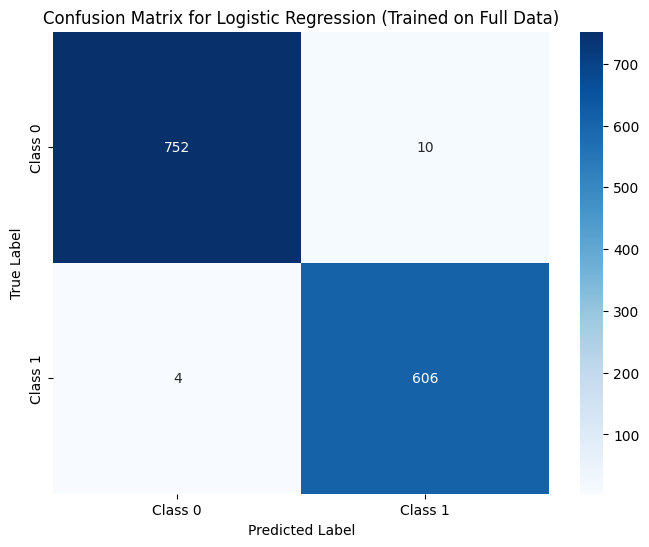

Best model (Logistic Regression) saved to logistic_regression_best_model.pkl


In [44]:
best_model.fit(X, y) # Treina o modelo final com todos os dados.
y_pred = best_model.predict(X) # Faz previsões com o modelo treinado.

cm = confusion_matrix(y, y_pred) # Cria a matriz de confusão.

plt.figure(figsize=(8, 6)) # Cria a figura para a matriz de confusão.
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1']) # Plota a matriz de confusão como um heatmap.
plt.xlabel('Predicted Label') # Define o rótulo do eixo x.
plt.ylabel('True Label') # Define o rótulo do eixo y.
plt.title(f'Confusion Matrix for {model_name} (Trained on Full Data)') # Define o título do gráfico.
plt.show() # Exibe o gráfico.


filename = f'{model_name.lower().replace(" ", "_")}_best_model.pkl' # Define o nome do arquivo para salvar o modelo.
with open(filename, 'wb') as file: # Abre o arquivo para escrita binária.
    pickle.dump(best_model, file) # Salva o modelo no arquivo.

print(f"Best model ({model_name}) saved to {filename}") # Imprime a confirmação de que o modelo foi salvo.

In [45]:
import pickle

filename = f'{model_name.lower().replace(" ", "_")}_best_model.pkl'

with open(filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Best model ({model_name}) saved to {filename}")

Best model (Logistic Regression) saved to logistic_regression_best_model.pkl
